# Speech Commands target model training

In [1]:
!pip install pydub
!pip install tensorflow-io

In [2]:
import os
import time

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio

from models.target import SCConvTarget
from util import plot_confusion_matrix

In [3]:
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'speech_commands_target'

In [4]:
if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

In [ ]:
BATCH_SIZE = 64

INPUT_SHAPE = (8192, 1)

## Speech Commands

### Data loading and preprocessing

Load the full [Speech Commands](https://arxiv.org/abs/1804.03209) dataset as a `tf.data.Dataset`:

In [5]:
(train_data, test_data, validation_data), info = tfds.load(
    'speech_commands',
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [6]:
tfds.as_dataframe(train_data.take(10), info)

audio  label
0  [1, -7, -8, -3, 3, 2, -2, 1, 0, 0, 4, 3, 0, -1...     11
1  [85, 446, 553, 232, -219, -308, -40, -14, -286...      0
2  [-35, -21, -29, -21, -29, -32, -15, -4, -12, -...     11
3  [-8, 16, 29, 32, 29, 25, 13, 10, 11, 10, 10, 5...     11
4  [2, -35, -21, -28, -63, -46, -34, -39, -53, -4...     11
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     11
6  [-10, -18, -19, -17, -20, -22, -19, -21, -12, ...      3
7  [4, 4, 6, 9, 7, 2, 4, 4, 3, 1, 0, 4, 5, 5, 3, ...      5
8  [59, -143, -227, -130, -298, -260, -147, -253,...     11
9  [-144, -157, -198, -203, -198, -195, -182, -19...      0

The dataset consists of audio files labeled with one of the following 12 classes:

In [7]:
info.features['label'].names

['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'up',
 'yes',
 '_silence_',
 '_unknown_']

#### Data filtering, normalization, resampling, and padding

Create a function for filtering out samples labeled as `_silence_` or `_unknown_`:

In [8]:
labels_to_remove = [
    info.features['label'].str2int('_silence_'),
    info.features['label'].str2int('_unknown_')
]

def label_filter(audio, label):
    return tf.reduce_all(tf.not_equal(label, labels_to_remove))

Create a function for normalizing audio tensors to $[-1.0, 1.0]$:

In [9]:
def normalize(audio, label):
    return tf.cast(audio, tf.float32) / 32768.0, label

Create a function for resampling audio files from 16 kHZ to 8192 Hz:

In [10]:
rate_in = 16000
rate_out = INPUT_SHAPE[0]

def resample(audio, label):
    return tfio.audio.resample(audio, rate_in, rate_out), label

Pad the data with zeroes to ensure that all samples are of the same size:

In [11]:
max_length = rate_out

def pad(audio, label):
    paddings = [[0, max_length - tf.shape(audio)[0]]]
    padded_audio = tf.pad(audio, paddings, 'CONSTANT', constant_values=0)

    return padded_audio, label

Preprocess the datasets:

In [12]:
def preprocess(dataset):
    return dataset.filter(
        label_filter
    ).map(
        normalize,
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        resample,
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        pad,
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [13]:
train_data = preprocess(train_data)
test_data = preprocess(test_data)
validation_data = preprocess(validation_data)

Filtering has reduced the datasets' sizes to the following:

In [16]:
print(f'training set size: {sum(1 for _ in train_data)}')
print(f'test set size: {sum(1 for _ in test_data)}')
print(f'validation set size: {sum(1 for _ in validation_data)}')

training set size: 30769
test set size: 4074
validation set size: 3703


#### Visualizing class imbalances

Create a function for plotting sample counts per class:

In [17]:
def plot_samples_per_label(dataset, data_name):
    samples_per_label = defaultdict(int)

    for audio, label in dataset:
        samples_per_label[label.numpy()] += 1
    
    plt.title(f'number of {data_name} samples per label')
    plt.bar(
        info.features['label'].names[:-2],
        samples_per_label.values()
    )

The datasets seem to be slightly imbalanced:

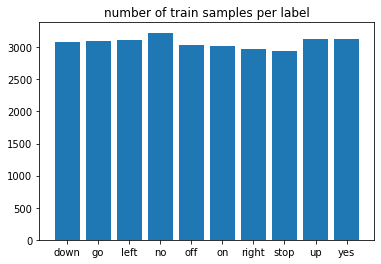

In [ ]:
plot_samples_per_label(train_data, 'train')

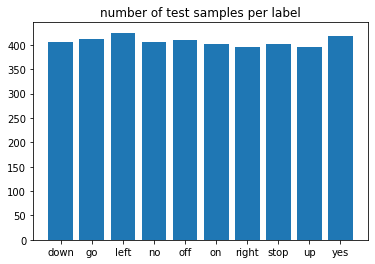

In [ ]:
plot_samples_per_label(test_data, 'test')

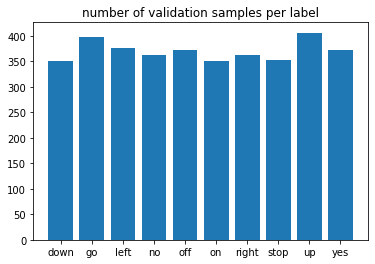

In [ ]:
plot_samples_per_label(validation_data, 'validation')

#### Waveform plots

Plot the waveforms of different samples:

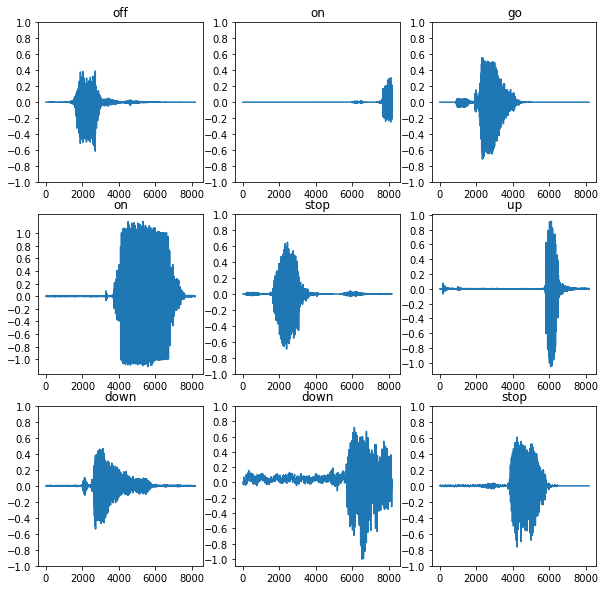

In [14]:
rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (audio, label) in enumerate(train_data.take(n)):
    row = i // cols
    col = i % cols
    ax = axes[row][col]

    ax.plot(audio.numpy())

    ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
    ax.set_title(info.features['label'].int2str(label.numpy()))

plt.show()

### Model

The implemented Speech Commands target model is a CNN model that works with 2D audio spectrograms.

If 1D inputs are given, the `transform_fn` parameter should be used for specifying a function that will convert them to spectrograms.

In [15]:
for audio, _ in train_data.take(1):
  print(f'Shape of audio samples: {audio.shape}')

Shape of audio samples: (8192,)


The `to_spectrogram` function will be used for converting 1D waveforms (without the channel dimension) to spectrograms by computing their Short-Time Fourier Transform (STFT).

The `tfio.audio.spectrogram` parameters were selected to create approximately square spectrograms, since the model later resizes them to $32 \times 32 \times 1$ tensors.

In [16]:
def to_spectrogram(inputs):
    spectrograms = tfio.audio.spectrogram(
        inputs,
        nfft=None,
        window=165,  # ~ 20 ms (1 phoneme) * 1e-3 * sample_rate
        stride=65  # adjusted to create an approx. square spectrogram
    )

    return tf.expand_dims(spectrograms, axis=-1)

In [17]:
for audio, _ in train_data.take(1):
    print(f'Spectrogram shape: {to_spectrogram(audio).shape}')

Spectrogram shape: (127, 129, 1)


Plot the spectrograms of different samples along with their waveforms:

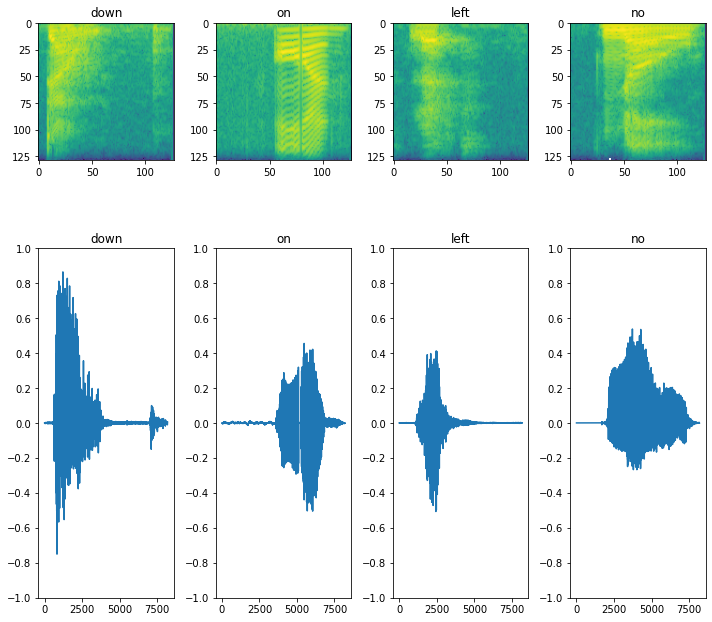

In [19]:
rows = 2
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (audio, label) in enumerate(train_data.take(cols)):
    spectrogram = tf.squeeze(to_spectrogram(audio))
    label = info.features["label"].int2str(label.numpy())

    ax = axes[0][i]
    ax.imshow(tf.math.log(tf.transpose(spectrogram)).numpy())
    ax.set_title(label)

    ax = axes[1][i]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.0, 1.2, 0.2))
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [20]:
target = SCConvTarget(transform_fn=to_spectrogram)

In [22]:
target.model.build((None, 127, 129, 1))
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Training

In [21]:
target.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [22]:
train_data = train_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [23]:
history = target.fit(
    train_data,
    validation_data=validation_data,
    epochs=5
)

Epoch 1/5
481/481 [==============================] - 113s 232ms/step - loss: 1.1793 - accuracy: 0.5963 - val_loss: 0.5702 - val_accuracy: 0.8039

In [24]:
weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
target.save_weights(weights_path)

print(f'Weights saved as {weights_path}')

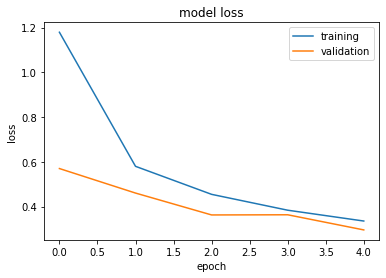

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

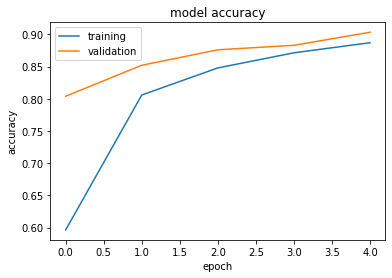

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

### Test set performance

In [27]:
test_audio = []
test_labels = []

for audio, label in test_data:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
loss, accuracy = target.evaluate(test_audio, test_labels, verbose=False)

print(f'test loss: {loss:.3}')
print(f'test accuracy: {accuracy:.3}')

test loss: 0.329
test accuracy: 0.901


#### Test set confusion matrix

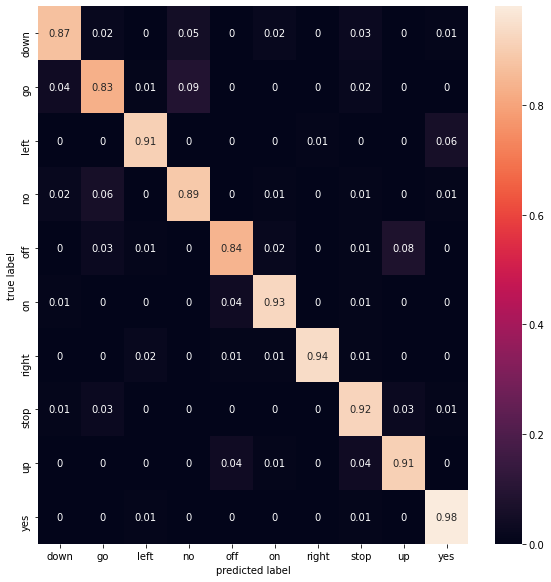

In [31]:
probs = target.predict(test_audio)

plot_confusion_matrix(
    test_labels,
    probs.argmax(axis=1),
    classes=range(10)
)